# NLP Disaster Tweets Classification with BERTweet (TensorFlow Version)

In this notebook, we will build a text classification model using the **BERTweet** transformer, fine-tuning it on the **Disaster Tweets** dataset.
Our goal is to predict whether a given tweet is about a real disaster or not.  
We will follow these steps:
- Load and explore the dataset
- Preprocess the text data
- Load the BERTweet Model and Tokenizer
- Fine-tune a pre-trained BERTweet model (TensorFlow)
- Evaluate the model
- Generate predictions and create a submission

Let's get started!

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=34f224819b542ea42f61a8acf60339231ca025d9f3a0293d1053853b72390e0a
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# Load and explore the dataset
Let's load the training and test datasets and quickly explore their structure.

In [4]:
train_df =  pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df =  pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Target Distribution
Before training, it's important to understand the distribution of the target classes.
Let's visualize how many disaster vs non-disaster tweets we have in the training dataset.

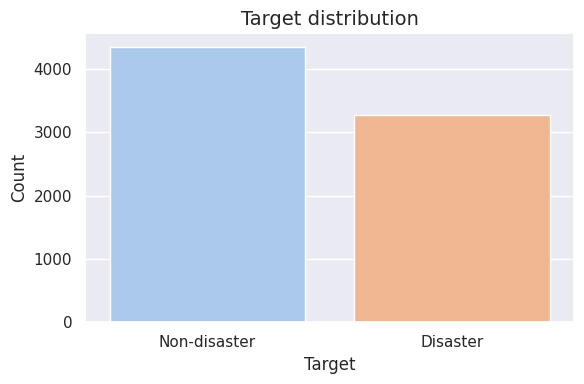

target
0    4342
1    3271
Name: count, dtype: int64

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x="target", palette="pastel")
plt.title("Target distribution", fontsize=14)
plt.xlabel("Target", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Non-disaster', 'Disaster'])
plt.tight_layout()
plt.show()

train_df.target.value_counts()

# Preprocess the text data
Before feeding the text into BERTweet, we will perform minimal preprocessing:

- **Copy the original datasets** to avoid modifying the raw data.
- **Remove duplicate tweets** based on the `text` field to reduce noise (train dataset only)
- **Drop unnecessary columns** such as `id`, `location`, and `keyword`, keeping only the relevant `text` and `target` columns.

Minimal preprocessing is important because BERTweet is pre-trained on noisy Twitter data, including mentions, hashtags, emojis, and misspellings.
Over-cleaning could remove valuable information.

In [8]:
df_train = train_df.copy()
df_test = test_df.copy()

df_train = df_train.drop_duplicates(subset='text')
df_train.drop(['id', 'location', 'keyword'], axis=1, inplace=True)
df_test.drop(['id', 'location', 'keyword'], axis=1, inplace=True)

df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Load the BERTweet Model and Tokenizer

We load the pre-trained **BERTweet-base** model (`vinai/bertweet-base`) and its corresponding tokenizer from Hugging Face.

After loading the model and tokenizer, we convert the pandas DataFrame into a Hugging Face `Dataset` object for more efficient data processing.

After that we will analyze the token length distribution of the training texts to select an appropriate maximum sequence length.

In [9]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

2025-04-28 11:41:39.229269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745840499.432133      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745840499.492726      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
MODEL_NAME = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

I0000 00:00:1745840523.421700      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#Import the Dataset class from the Hugging Face datasets library
from datasets import Dataset

#Convert the pandas DataFrame into a Dataset object
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)

# Extract the train and validation datasets separately
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

# Extract the target labels as numpy arrays
# This will be useful later for calculating evaluation metrics
y_val = np.array(val_dataset["target"])
y_train = np.array(train_dataset["target"])

In [12]:
token_lens = [len(tokenizer(text)['input_ids']) for text in train_dataset['text']]

print("Mean length:", np.mean(token_lens))
print("Max length:", np.max(token_lens))
print("95% cover:", np.percentile(token_lens, 95))

Mean length: 29.197767410863047
Max length: 91
95% cover: 44.0


So we can safely use `128 length` for padding

In [13]:
# Define tokenization function
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128, return_tensors="tf")

# Apply tokenization
train_dataset_tokenized = train_dataset.map(tokenize, batched=True, remove_columns=['text'])
val_dataset_tokenized = val_dataset.map(tokenize, batched=True, remove_columns= ['text'])
test_dataset_tokenized = test_dataset.map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [14]:
# Convert the tokenized Datasets into TensorFlow Datasets
# This is necessary for training the model in TensorFlow/Keras

tf_train_dataset = train_dataset_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],  # Model inputs
    label_cols="target",                      # Labels (target column)
    batch_size=32                             # Batch size for training
)

tf_val_dataset = val_dataset_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols="target",
    shuffle=False,
    batch_size=32
)

tf_test_dataset = test_dataset_tokenized.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    shuffle=False,        # Important! We dont want to shuffle test dataset 
    batch_size=32         
)

# Fine-Tune the BERTweet Model

Now that we have tokenized and prepared our datasets, it's time to fine-tune the pre-trained BERTweet model.

We will:
- Compile the model with an Adam optimizer and a sparse categorical cross-entropy loss function (since it's a two-class classification problem)
- Compute class weights to handle any class imbalance in the training data.
- Train the model using our prepared training and validation datasets.

In [15]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [16]:
# Calculate class weights to address class imbalance
# This helps the model not to be biased towards the majority class
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights into a dictionary format
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.8741625400524323, 1: 1.168158816660179}


In [17]:
# Fit
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=2, class_weight=class_weights)

Epoch 1/2


I0000 00:00:1745840574.649119      70 service.cc:148] XLA service 0x7c893a4cbf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745840574.649760      70 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745840574.722206      70 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745840574.842086      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 [==============================] - 152s 541ms/step - loss: 0.5222 - accuracy: 0.7433 - val_loss: 0.4266 - val_accuracy: 0.8215
Epoch 2/2
188/188 [==============================] - 96s 509ms/step - loss: 0.3849 - accuracy: 0.8474 - val_loss: 0.4210 - val_accuracy: 0.8374


# Evaluate the Model

In [18]:
# Generate predicted logits for the training and val datasets
y_train_pred_probs = model.predict(tf_train_dataset).logits
y_val_pred_probs = model.predict(tf_val_dataset).logits

47/47 [==============================] - 8s 163ms/step


In [19]:
# Convert predicted probabilities into predicted class labels (0 or 1)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [21]:
print("Train classification report:")
print(classification_report(y_train, y_train_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3433
           1       0.89      0.85      0.87      2569

    accuracy                           0.89      6002
   macro avg       0.89      0.88      0.89      6002
weighted avg       0.89      0.89      0.89      6002



In [22]:
print("Validation classification report:")
print(classification_report(y_val, y_val_pred))

Validation classification report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       872
           1       0.82      0.79      0.80       629

    accuracy                           0.84      1501
   macro avg       0.83      0.83      0.83      1501
weighted avg       0.84      0.84      0.84      1501



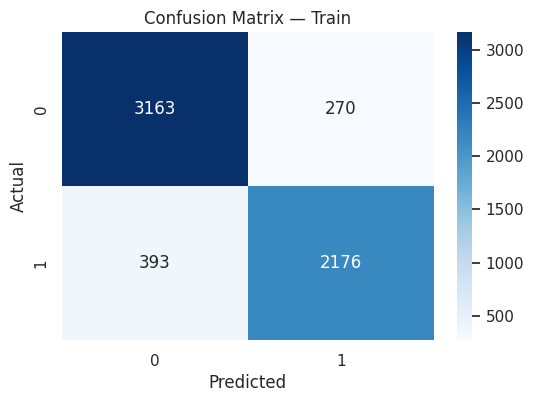

In [23]:
plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix — Train")

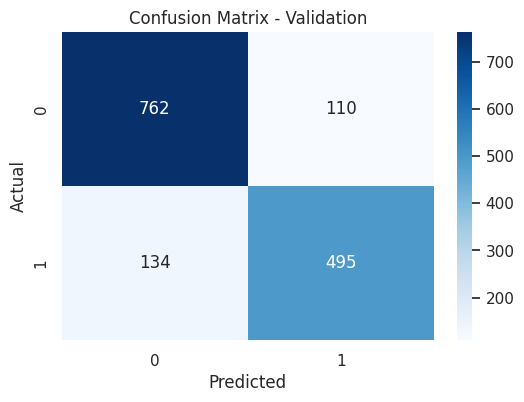

In [24]:
plot_confusion_matrix(y_val, y_val_pred, 'Confusion Matrix - Validation')

# Generate predictions and create a submission
We got `F1-score = 0.84` on our validation Dataset

And finally, we will generate predictions on the test dataset and create a submission file

In [25]:
# Generate predictions
test_pred_probs = model.predict(tf_test_dataset).logits
test_preds = np.argmax(test_pred_probs, axis=1)

102/102 [==============================] - 21s 163ms/step


In [26]:
# Load the sample submission file
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [27]:
sample_submission['target'] = test_preds

In [28]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.413423
std,3146.427221,0.492523
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [29]:
# Save the submission
sample_submission.to_csv("submission.csv", index=False)